# COMP9418 Assignment 2

## *Tasks TODO*
- parameter initialization
- mean negative log probability
- sample predictions.txt generator


In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import hmmlearn
from hmmlearn.hmm import GaussianHMM, GMMHMM
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# make sure it's version 0.2.1 (install from github, not pip)
# pip install git+https://github.com/hmmlearn/hmmlearn.git
hmmlearn.__version__

'0.2.1'

In [3]:
seed = 1234
rng = np.random.RandomState(seed)

In [4]:
# Load the data
trainData = sio.loadmat('./trajectories_train.mat')
testData = sio.loadmat('./trajectories_xtest.mat')

In [5]:
# Clean up the data
xtrain = trainData['xtrain'].reshape((1429))
ytrain = trainData['ytrain'].reshape((1429))
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.3, random_state=rng)
xtest = testData['xtest'].reshape((1429))
key = trainData['key']
key = [item[0] for item in key.reshape((20))]

In [6]:
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)
print(xtest.shape)

(1000,)
(1000,)
(429,)
(429,)
(1429,)


# Train and Validation Splits

In [7]:
idx = 100

In [8]:
x = xtrain[idx]
y = ytrain[idx]

In [9]:
def plot_char(data):
    start_x = 0
    start_y = 0
    plt.plot(start_x, start_y, 'ro')
    for vel_h, vel_v, alpha in zip(data[0,], data[1, ], 1/(1 + np.exp(-x[2, ]/np.sum(x[1, ])))):
        start_x = start_x + vel_h
        start_y = start_y + vel_v
        plt.plot(start_x, start_y,'bo', alpha = alpha)
    plt.title('Character ' + key[y-1])
    plt.show()

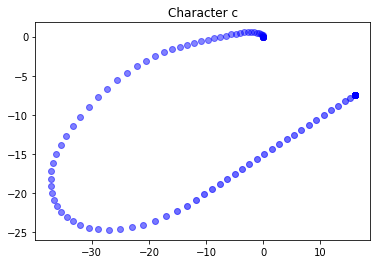

In [10]:
plot_char(x)

# Data Cleaning and Preparation

In [11]:
xtrain = np.asarray([seq.T for seq in xtrain])
xval = np.asarray([seq.T for seq in xval])
xtest = np.asarray([seq.T for seq in xtest])

In [12]:
print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(1000,)
(429,)
(1429,)


In [13]:
lengths_train = list(map(lambda x: x.shape[0], xtrain))
lengths_test = list(map(lambda x: x.shape[0], xtest))

In [14]:
label_enc = LabelEncoder().fit(ytrain)
label_enc.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=uint8)

# Generative Classifier

In [15]:
def log_likelihood(hmm, sequence):

    logprob_frame = hmm._compute_log_likelihood(sequence)
    logprob_sequence, _ =  hmm._do_forward_pass(logprob_frame)

    return logprob_sequence

def log_likelihoods(hmm, sequences):

    ll = lambda seq: log_likelihood(hmm, seq)

    return np.fromiter(map(ll, sequences), dtype='float64')

def log_likelihoods_cond(cond_hmms, sequences):

    ll = lambda hmm: log_likelihoods(hmm, sequences)

    return np.vstack(map(ll, cond_hmms))

In [16]:
class GenerativeClassifierHMM(BaseEstimator, ClassifierMixin):

    def __init__(self, hmm=GaussianHMM()):

        self.hmm = hmm
        self.class_cond_hmms_ = []

    def fit(self, sequences, labels):

        class_counts = np.bincount(labels)
        self.logprior = np.log(class_counts / np.sum(class_counts))

        for c in range(np.max(labels)+1):

            sequences_c = sequences[labels == c]

            X_c = np.vstack(sequences_c)
            lengths_c = list(map(len, sequences_c))
            
            class_cond_hmm = clone(self.hmm, safe=True)
            class_cond_hmm.fit(X_c, lengths=lengths_c)

            self.class_cond_hmms_.append(class_cond_hmm)

        return self

    def predict(self, sequences):

        log_likelihood_ = log_likelihoods_cond(self.class_cond_hmms_, sequences)

        log_post_unnorm = log_likelihood_ + self.logprior.reshape(-1, 1)

        return np.argmax(log_post_unnorm, axis=0)

# Guassian HMM

In [17]:
# Parameters
n_states = 5

# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [18]:
hmm = GaussianHMM(n_components=n_states, 
                  init_params='mc',
                  n_iter=10,
                  random_state=seed)
hmm.startprob_ = pi0
hmm.transmat_  = trans0

In [19]:
# due to https://github.com/hmmlearn/hmmlearn/issues/158 and 
# https://github.com/hmmlearn/hmmlearn/issues/175
# the fitting process is going to give a LOT fo warnings
# so we hide them in this notebook
import warnings
warnings.filterwarnings('ignore')

In [88]:
hmm_classifier = GenerativeClassifierHMM(hmm)
hmm_classifier.fit(xtrain, 
                   label_enc.transform(ytrain))

GenerativeClassifierHMM(hmm=GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='mc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=5, n_iter=10, params='stmc',
      random_state=1234, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False))

In [89]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))

In [90]:
print('Accuarcy', (y_val_pred == yval).mean())

Accuarcy 0.801864801865


### Basic Corss Validation

In [82]:
cv1_results = {}
for k in range(5, 31):
    pi0 = np.eye(1, k)[0]
    trans0 = np.diag(np.ones(k)) + np.diag(np.ones(k-1), 1)
    trans0 /= trans0.sum(axis=1).reshape(-1, 1)
    hmm = GaussianHMM(n_components=k, 
                      init_params='mc',
                      n_iter=10,
                      random_state=seed)
    hmm.startprob_ = pi0
    hmm.transmat_  = trans0
    hmm_classifier = GenerativeClassifierHMM(hmm)
    hmm_classifier.fit(xtrain, 
                       label_enc.transform(ytrain))
    y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))
    accuarcy = (y_val_pred == yval).mean()
    cv1_results[k] = accuarcy
    print('Accuarcy', k, accuarcy)

Accuarcy 5 0.801864801865
Accuarcy 6 0.785547785548
Accuarcy 7 0.862470862471
Accuarcy 8 0.86013986014
Accuarcy 9 0.890442890443
Accuarcy 10 0.897435897436
Accuarcy 11 0.892773892774
Accuarcy 12 0.878787878788
Accuarcy 13 0.888111888112
Accuarcy 14 0.899766899767
Accuarcy 15 0.916083916084
Accuarcy 16 0.904428904429
Accuarcy 17 0.911421911422
Accuarcy 18 0.904428904429
Accuarcy 19 0.932400932401
Accuarcy 20 0.925407925408
Accuarcy 21 0.913752913753
Accuarcy 22 0.918414918415
Accuarcy 23 0.920745920746
Accuarcy 24 0.913752913753
Accuarcy 25 0.909090909091
Accuarcy 26 0.911421911422
Accuarcy 27 0.918414918415
Accuarcy 28 0.920745920746
Accuarcy 29 0.916083916084
Accuarcy 30 0.911421911422


# Gaussian Mixture HMM

**Note**:
I was getting some results (70%) with these parameters when I was on version 0.2.0 but after updating to the latest
version (0.2.1), GMMHMM hasn't been great and it's taking too long to run. There are some open issues on their Github which seem to suggest GMMHMM is a bit buggy atm.

In [62]:
# Parameters
n_states = 5
n_mix = 1
# initial guess for EM
pi0 = np.eye(1, n_states)[0] # start probability
pi0

# initial guess for EM
# transition matrix
trans0 = np.diag(np.ones(n_states)) + np.diag(np.ones(n_states-1), 1)
trans0 /= trans0.sum(axis=1).reshape(-1, 1)
trans0

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [63]:
gmmhmm = GMMHMM(n_components=n_states, 
                n_mix=n_mix,
                covariance_type='diag',
                init_params='mc',
                n_iter=500,
                random_state=rng)
gmmhmm.startprob_ = pi0
gmmhmm.transmat_  = trans0

In [64]:
hmm_classifier = GenerativeClassifierHMM(gmmhmm)
hmm_classifier.fit(xtrain, label_enc.transform(ytrain))

KeyboardInterrupt: 

In [ ]:
y_val_pred = label_enc.inverse_transform(hmm_classifier.predict(xval))

In [ ]:
print('Accuarcy', (y_val_pred == yval).mean())

### Basic Corss Validation